# Imports and Dependencies
Start your notebook by importing any necessary libraries and dependencies that you'll need throughout your code. This could include things like NumPy, Pandas, scikit-learn, or TensorFlow.

In [6]:
#conda install scikit-learn

In [7]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC
from sklearn import metrics, model_selection, tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import random
import torch
from torch import nn, optim
import math
from IPython import display
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit

In [8]:
# !pip show torch

In [9]:
import random
random.seed(12289065)

# Data Preparation
Load your dataset into memory, and perform any necessary preprocessing steps. This might include tasks like cleaning the data, handling missing values, feature scaling, encoding categorical variables, and so on.

In [16]:
# Loading the dataset into a Pandas Dataframe 
df = pd.read_csv("musicData.csv") 
df = df.drop(columns=['artist_name','track_name'])

In [17]:
# Identify target variable column and separate it from features
target_col = 'music_genre'
# y = df[target_col]
X = df.drop(columns=[target_col])

In [18]:
# Overview of the data 
# ProfileReport(df)

In [19]:
# let's quickly preview the dataset
df
df.head()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [20]:
print(df.shape)

(50005, 16)


Some preliminary cleaning before visualizing your data to ensure that the visualizations accurately reflect the data you have. For example, you may want to remove or impute any missing data before visualizing the distributions of the acoustic features. Additionally, you may want to transform the categorical data into numerical data before exploring relationships between features.

### Checking for outliers

A scatter plot matrix can be a good way to visualize the relationship between multiple predictors and identify outliers. In a scatter plot matrix, each predictor is plotted against all other predictors in the form of scatter plots. Outliers will be visible as points that fall outside the general pattern of the data.
Indeed, exploring the pairwise relationships between the features can be a useful step in preparing the data for classification, even if the ultimate goal is to classify the genre of music.

In [21]:
# Use Seaborn to create a scatter matrix plot
#sns.pairplot(df, hue='music_genre')

### Handling missing data
There is randomly missing data, e.g. some of the durations of some of the songs are missing, as well as some of the auditory feature values. There are not many missing values, but you have to handle them somehow, either by imputation or by removing the missing data in some reasonable way.

In [22]:
# Handling missing data
df.isnull().sum()

instance_id         5
popularity          5
acousticness        5
danceability        5
duration_ms         5
energy              5
instrumentalness    5
key                 5
liveness            5
loudness            5
mode                5
speechiness         5
tempo               5
obtained_date       5
valence             5
music_genre         5
dtype: int64

As there are only 5 missing values in the whole dataset per column and there are only 18 columns, i.e., 90 rows out of 50,005(0.17%) which we can even drop. 

In [23]:
# The inplace=True parameter will modify the DataFrame in place, 
# meaning that it will be updated and the missing values will be removed permanently. 
# df.dropna(inplace=True)

df = df.dropna()
df.isnull().sum()

instance_id         0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
obtained_date       0
valence             0
music_genre         0
dtype: int64

In [24]:
# Count the number of '?' values in each column of the DataFrame
print(df.isin(['?']).sum())

instance_id            0
popularity             0
acousticness           0
danceability           0
duration_ms            0
energy                 0
instrumentalness       0
key                    0
liveness               0
loudness               0
mode                   0
speechiness            0
tempo               4980
obtained_date          0
valence                0
music_genre            0
dtype: int64


We found 4980 missing values in one column "tempo" which is quite a large number, and if it is only for one column, it might be a good idea to drop that column from your analysis. 

There are only 4980 ? labeled values in the whole dataset for one column and there are only 16 columns, i.e., 4980 rows out of 50,005(10%) of the dataset. As 10% is a large amount of data we can do imputation by replacing missing values with the mean. 

In [25]:
# df = df.drop(columns=['tempo'])
# instead of dropping tempo column which will make us loose a lot of data, we will do imputation with replacing with the mean

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# Assuming 'df' is your pandas DataFrame containing the dataset

# Replace '?' values with NaN
df['tempo'].replace('?', np.nan, inplace=True)

# Reshape the 'tempo' column to a 2D array
tempo_2d = df['tempo'].values.reshape(-1, 1)

# Initialize the imputer with the mean strategy
imputer = SimpleImputer(strategy='mean')

# Impute missing values by replacing them with the mean
imputed_tempo = imputer.fit_transform(tempo_2d)

# Update the 'tempo' column with the imputed values
df['tempo'] = imputed_tempo

# The 'tempo' column now contains the imputed values


### Variable encoding 
* The acoustic features are unlikely to be normally distributed.
* Some of the data is provided in string format, e.g. the key. This will need to be transformed into numerical data to be useful.
* Some of the data is provided in categorical format, e.g. mode. This will need to be dummy coded. *The category labels of the genres will need to be transformed into numerical labels.
* Make sure not to normalize categorical values (like mode) for the purposes of doing dimensionality reduction.

### Standardize non categorical features
As the project warns us to make sure not to normalize categorical values (like mode). We will only categorise non categorical variables, especially targetting The acoustic features which are unlikely to be normally distributed.


In [26]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Select columns to standardize
columns_to_standardize = ['valence', 'speechiness', 'loudness', 'liveness' , 'instrumentalness', 'energy', 'duration_ms', 'danceability', 'acousticness', 'popularity', 'instance_id']

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the selected columns
scaler.fit(df[columns_to_standardize])

# Transform the selected columns
df[columns_to_standardize] = scaler.transform(df[columns_to_standardize])


### Transformation of the features in string format and categorical format into numerical data to be useful

* Some of the data is provided in string format, e.g. the key. This will need to be transformed into numerical data to be useful.

* Some of the data is provided in categorical format, e.g. mode. This will need to be dummy coded. *The category labels of the genres will need to be transformed into numerical labels.

* The category labels of the genres will need to be transformed into numerical labels.


To transform text-based features into numerical data, you can use a technique called one-hot encoding. One-hot encoding converts categorical variables into binary vectors that can be used in machine learning algorithms.

In [27]:
# finding the categorical variables and variables in string format 

string_columns = []
for column in df.columns:
    if df[column].dtype == 'object': # check if column dtype is object (i.e., string)
        string_columns.append(column)
print ('The categorical features are: ', string_columns)

The categorical features are:  ['key', 'mode', 'obtained_date', 'music_genre']


In [28]:
from sklearn.preprocessing import OneHotEncoder

# PROCESS - ONE HOT ENCODING for 'key', 'mode', 'obtained_date', 'music_genre'

# updated code to perform one-hot encoding on the target variable instead of label encoding:

# concatenate your encoded target variable with your feature columns
features = df.drop('music_genre', axis=1)

# Define the categorical columns to be one-hot encoded
categorical_cols = ['key', 'mode', 'obtained_date']

# One-hot encode the categorical columns
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
features = pd.DataFrame(onehot_encoder.fit_transform(features[categorical_cols]).toarray(),
                          columns=onehot_encoder.get_feature_names_out(categorical_cols))

# One-hot encode the target variable (music_genre column)
target_encoder = OneHotEncoder(handle_unknown='ignore')
encoded_target = pd.DataFrame(target_encoder.fit_transform(df[['music_genre']]).toarray(),
                              columns=target_encoder.get_feature_names_out(['music_genre']))

# concatenate the encoded target variable with the feature columns
df_encoded = pd.concat([encoded_target, features, df.drop(columns=categorical_cols + ['music_genre'])], axis=1)


In [29]:
column_names = df_encoded.columns.tolist()

# Print the column names
print(column_names)

['music_genre_Alternative', 'music_genre_Anime', 'music_genre_Blues', 'music_genre_Classical', 'music_genre_Country', 'music_genre_Electronic', 'music_genre_Hip-Hop', 'music_genre_Jazz', 'music_genre_Rap', 'music_genre_Rock', 'key_A', 'key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F', 'key_F#', 'key_G', 'key_G#', 'mode_Major', 'mode_Minor', 'obtained_date_0/4', 'obtained_date_1-Apr', 'obtained_date_3-Apr', 'obtained_date_4-Apr', 'obtained_date_5-Apr', 'instance_id', 'popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


In [30]:
# print shape of new new encoded df 
print('New shape of df', df_encoded.shape)
df_encoded.head()

# N.B not all 31 are features, the music_genre target variable was also one hot encoded  

New shape of df (50005, 41)


,music_genre_Alternative,music_genre_Anime,music_genre_Blues,music_genre_Classical,music_genre_Country,music_genre_Electronic,music_genre_Hip-Hop,music_genre_Jazz,music_genre_Rap,music_genre_Rock,...,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.883886,0.524878,-1.719534,1.289876,1.875809,-0.488113,0.638132,-0.185322,100.889,1.225073
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.860390,0.356933,-0.023001,1.097101,2.361357,-0.432433,0.339248,-0.627258,115.002,0.302431
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.888632,0.345737,-0.043830,0.586813,-0.521812,2.104140,0.732892,-0.582867,127.994,-0.498812
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.823184,1.207853,-0.422611,0.378918,-0.550300,-0.228269,0.752201,1.434452,128.014,-0.753752
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.883974,0.446504,0.008676,-0.048212,2.235361,-0.228269,0.465324,-0.515787,145.036,-0.539278


# Exploratory Data Analysis
In this section, you can explore the data to gain insights about the distribution of features, correlation between features, and identify any patterns or trends in the data.

## Dimentionality reduction
Dimensionality reduction is often part of exploratory data analysis as it helps in visualizing and understanding high-dimensional data by reducing the number of features. By reducing the dimensionality of the data, we can better understand the relationships between variables and identify patterns in the data. 

The choice of dimensionality reduction technique depends on various factors such as the size and complexity of the dataset, the goal of the analysis, and the computational resources available.
For the project, we have 18 features and our goal is to perform a classification task, it may be appropriate to use a supervised dimensionality reduction technique such as Linear Discriminant Analysis (LDA) or Quadratic Discriminant Analysis (QDA), which aim to maximize the separation between different classes.

N.B: Note that the dimentionality reduction is not used for clustering the data, but for identifying the most important variables that can be used in classification models.

In [31]:
df_encoded.isnull().sum()

music_genre_Alternative    5
music_genre_Anime          5
music_genre_Blues          5
music_genre_Classical      5
music_genre_Country        5
music_genre_Electronic     5
music_genre_Hip-Hop        5
music_genre_Jazz           5
music_genre_Rap            5
music_genre_Rock           5
key_A                      5
key_A#                     5
key_B                      5
key_C                      5
key_C#                     5
key_D                      5
key_D#                     5
key_E                      5
key_F                      5
key_F#                     5
key_G                      5
key_G#                     5
mode_Major                 5
mode_Minor                 5
obtained_date_0/4          5
obtained_date_1-Apr        5
obtained_date_3-Apr        5
obtained_date_4-Apr        5
obtained_date_5-Apr        5
instance_id                5
popularity                 5
acousticness               5
danceability               5
duration_ms                5
energy        

In [32]:
# drop in case there is any left missing data 
df_encoded = df_encoded.dropna()
df_encoded.isnull().sum()

music_genre_Alternative    0
music_genre_Anime          0
music_genre_Blues          0
music_genre_Classical      0
music_genre_Country        0
music_genre_Electronic     0
music_genre_Hip-Hop        0
music_genre_Jazz           0
music_genre_Rap            0
music_genre_Rock           0
key_A                      0
key_A#                     0
key_B                      0
key_C                      0
key_C#                     0
key_D                      0
key_D#                     0
key_E                      0
key_F                      0
key_F#                     0
key_G                      0
key_G#                     0
mode_Major                 0
mode_Minor                 0
obtained_date_0/4          0
obtained_date_1-Apr        0
obtained_date_3-Apr        0
obtained_date_4-Apr        0
obtained_date_5-Apr        0
instance_id                0
popularity                 0
acousticness               0
danceability               0
duration_ms                0
energy        

### PCA 
When performing PCA (Principal Component Analysis), it is common practice to exclude the target variable from the analysis. PCA is typically used for dimensionality reduction and exploring the underlying structure of the feature variables. The target variable is not considered in the process because PCA focuses on the variance in the feature space.

Therefore, we should drop the target variable from your dataset before applying PCA. This ensures that the PCA analysis is based solely on the feature variables and helps to avoid any potential bias introduced by including the target variable.

In [33]:
# Drop music genre columns
target_columns = ['music_genre_Alternative', 'music_genre_Anime', 'music_genre_Blues','music_genre_Classical', 'music_genre_Hip-Hop','music_genre_Electronic', 'music_genre_Jazz', 'music_genre_Rap', 'music_genre_Rock' , 'music_genre_Country']
X = df_encoded.drop(columns=target_columns)
X.shape 

(49995, 31)

#### Silhouette Plot

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Define the range of number of components to try
n_components_range = range(2, 11)

# Initialize an empty list to store silhouette scores
silhouette_scores = []

# Iterate over different numbers of components
for n_components in n_components_range:
    # Perform PCA with the current number of components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # Apply K-means clustering to the transformed data
    kmeans = KMeans(n_clusters=5)  # Set the desired number of clusters
    labels = kmeans.fit_predict(X_pca)

    # Calculate the silhouette score
    silhouette_scores.append(silhouette_score(X_pca, labels))

# Plot the silhouette scores
plt.plot(n_components_range, silhouette_scores)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


By examining the plot of silhouette scores, we can identify the number of components that maximizes the score. Indeed, the silhouette score is just one metric, therefore, we also computing the number of Eigenvalues above 1 to find the ideal number of components. 

#### Computing Eigenvalues

We look for how many Eigenvalues are above 1? How much of the variance is explained by these two dimensions, and how would you interpret them? Plotting the 2D solution (projecting the data on the principal components portraying the most variance. 

In [ ]:
import numpy as np

# Assume we have a dataset X with shape (n, p)
n, p = X.shape

# Calculate the covariance matrix
Cx = (1/n) * (X - X.mean(axis=0)).T.dot(X - X.mean(axis=0))

# Find the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(Cx)

# Print the eigenvalues
print("Eigenvalues:", eigenvalues)

In [ ]:
import numpy as np

# Assume we have a covariance matrix Cx and we have already computed its eigenvalues
eigenvalues, _ = np.linalg.eig(Cx)

# Check if eigenvalues are greater than 1
keep_components = eigenvalues > 1

# Print the number of components to keep
n_components = np.sum(keep_components)
print("Number of components to keep (number of Eigenvalues above 1):", n_components)

In [ ]:
# Projecting the data 

# fit PCA model
pca = PCA(n_components=5)
pca.fit(X)

# project data onto first 5 principal components
X_proj = pca.transform(X)[:, :5]

# calculate variance explained by first 5 principal components
variance_explained = np.sum(pca.explained_variance_ratio_[:5])

print("Variance explained by first 5 principal components:", variance_explained)

By looking at the variances explained by the first 5 principal components, 
you can assess how much of the original variability in the data is being captured in the 2D projection.

#### Plotting the 2D solution (projecting the data on the first 2 principal components)

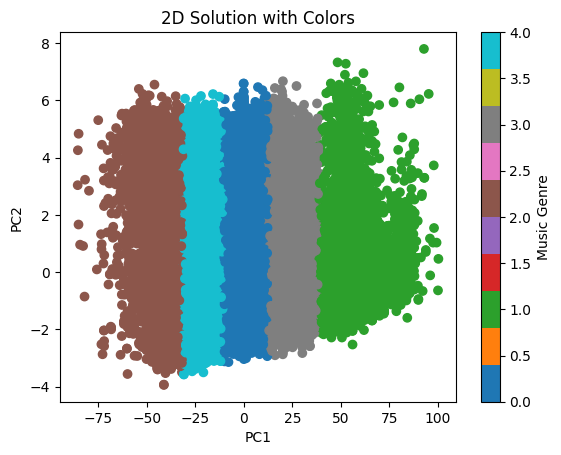

In [165]:
import matplotlib.pyplot as plt

# Define colors for each data point based on the labels
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'brown', 'pink']

# Plot 2D solution with colors
plt.scatter(X_proj[:, 0], X_proj[:, 1], c=labels, cmap='tab10')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D Solution with Colors')
plt.colorbar(label='Music Genre')
plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-162-439bdace2e63>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', len(genres))
<ipython-input-162-439bdace2e63>:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_pca[indices, 0], X_pca[indices, 1], X_pca[indices, 2], c=color_map(i), label=ge

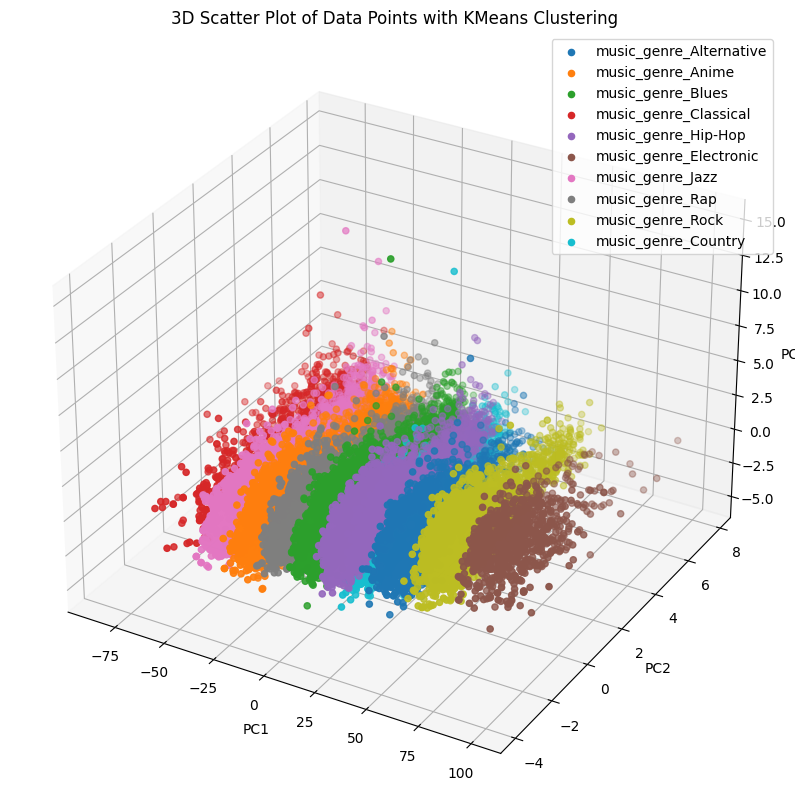

In [162]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Sample data (replace with your actual data)
# X = np.random.rand(100, 10)

# Music genres (replace with your actual genres)
genres = ['music_genre_Alternative', 'music_genre_Anime', 'music_genre_Blues','music_genre_Classical', 'music_genre_Hip-Hop','music_genre_Electronic', 'music_genre_Jazz', 'music_genre_Rap', 'music_genre_Rock' , 'music_genre_Country']

# Compute PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=len(genres))
cluster_labels = kmeans.fit_predict(X)

# Create a figure and axis for the plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Assign colors to genres
color_map = plt.cm.get_cmap('tab10', len(genres))

# Plot the data points with color coding based on genres
for i, genre in enumerate(genres):
    indices = np.where(cluster_labels == i)[0]
    ax.scatter(X_pca[indices, 0], X_pca[indices, 1], X_pca[indices, 2], c=color_map(i), label=genre)

# Set labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot of Data Points with KMeans Clustering')

# Add legend
ax.legend()

# Show the plot
plt.show()



In [163]:
print(X_pca.shape) 

(49995, 3)


In the scatter plot, each point represents a song in a 3-dimensional space defined by the first 3 principal components. You can use this plot to visually inspect if there are any clusters of songs that belong to a specific genre or if the songs are evenly distributed across the space. This can give you an idea of how well a machine learning model might be able to predict the genre based on the selected features. 
We can almost perfectly see the clusters with each corresponding to a music genre. 

#### Calculate the explained variance ratio for each principal component

You can also calculate the explained variance ratio for each principal component to see how much of the variance in the data is captured by each component. This can help you decide how many principal components to keep for your analysis.

In [166]:
# Compute the explained variance ratio for each principal component
explained_var_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio for each principal component
for i, var_ratio in enumerate(explained_var_ratio):
    print(f'Explained variance ratio for principal component {i+1}: {var_ratio:.3f}')

Explained variance ratio for principal component 1: 0.986
Explained variance ratio for principal component 2: 0.004
Explained variance ratio for principal component 3: 0.001


# Model Development
 In this section, you can split the data into training and testing sets, choose and train a suitable machine learning model (such as a decision tree or a random forest), and evaluate the model's performance on the test set.

## Train test split 
According to the capstone project requirements we need to make sure to do the following train/test split: For *each* genre, use 500 randomly picked songs for the test set and the other 4500 songs from that genre for the training set. So the complete test set will be 5000x1 randomly picked genres (one per song, 500 from each genre). Use all the other data in the training set and make sure there is no leakage."

In [167]:
df_encoded

,music_genre_Alternative,music_genre_Anime,music_genre_Blues,music_genre_Classical,music_genre_Country,music_genre_Electronic,music_genre_Hip-Hop,music_genre_Jazz,music_genre_Rap,music_genre_Rock,...,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.883886,0.524878,-1.719534,1.289876,1.875809,-0.488113,0.638132,-0.185322,100.889,1.225073
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.860390,0.356933,-0.023001,1.097101,2.361357,-0.432433,0.339248,-0.627258,115.002,0.302431
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.888632,0.345737,-0.043830,0.586813,-0.521812,2.104140,0.732892,-0.582867,127.994,-0.498812
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.823184,1.207853,-0.422611,0.378918,-0.550300,-0.228269,0.752201,1.434452,128.014,-0.753752
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.883974,0.446504,0.008676,-0.048212,2.235361,-0.228269,0.465324,-0.515787,145.036,-0.539278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.895907,2.120353,0.446523,0.360018,-0.557976,0.625504,0.357259,0.398665,99.997,0.002976
49996,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.791250,1.515752,0.069125,-0.622758,2.140095,-0.463366,-0.162624,-0.415168,103.816,0.557371
49997,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.396625,0.160998,0.259899,0.420497,-0.558074,-0.426246,0.454940,3.219952,98.008,-0.304571
49998,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.491062,-0.247668,0.198339,0.492315,-0.558074,1.961844,0.104295,2.894419,167.655,0.982273


In [168]:
print(df_encoded.columns)
df_encoded.isnull().sum()

Index(['music_genre_Alternative', 'music_genre_Anime', 'music_genre_Blues',
       'music_genre_Classical', 'music_genre_Country',
       'music_genre_Electronic', 'music_genre_Hip-Hop', 'music_genre_Jazz',
       'music_genre_Rap', 'music_genre_Rock', 'key_A', 'key_A#', 'key_B',
       'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F', 'key_F#',
       'key_G', 'key_G#', 'mode_Major', 'mode_Minor', 'obtained_date_0/4',
       'obtained_date_1-Apr', 'obtained_date_3-Apr', 'obtained_date_4-Apr',
       'obtained_date_5-Apr', 'instance_id', 'popularity', 'acousticness',
       'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness',
       'loudness', 'speechiness', 'tempo', 'valence'],
      dtype='object')


music_genre_Alternative    0
music_genre_Anime          0
music_genre_Blues          0
music_genre_Classical      0
music_genre_Country        0
music_genre_Electronic     0
music_genre_Hip-Hop        0
music_genre_Jazz           0
music_genre_Rap            0
music_genre_Rock           0
key_A                      0
key_A#                     0
key_B                      0
key_C                      0
key_C#                     0
key_D                      0
key_D#                     0
key_E                      0
key_F                      0
key_F#                     0
key_G                      0
key_G#                     0
mode_Major                 0
mode_Minor                 0
obtained_date_0/4          0
obtained_date_1-Apr        0
obtained_date_3-Apr        0
obtained_date_4-Apr        0
obtained_date_5-Apr        0
instance_id                0
popularity                 0
acousticness               0
danceability               0
duration_ms                0
energy        

In [169]:
print(df_encoded.isnull().sum())

music_genre_Alternative    0
music_genre_Anime          0
music_genre_Blues          0
music_genre_Classical      0
music_genre_Country        0
music_genre_Electronic     0
music_genre_Hip-Hop        0
music_genre_Jazz           0
music_genre_Rap            0
music_genre_Rock           0
key_A                      0
key_A#                     0
key_B                      0
key_C                      0
key_C#                     0
key_D                      0
key_D#                     0
key_E                      0
key_F                      0
key_F#                     0
key_G                      0
key_G#                     0
mode_Major                 0
mode_Minor                 0
obtained_date_0/4          0
obtained_date_1-Apr        0
obtained_date_3-Apr        0
obtained_date_4-Apr        0
obtained_date_5-Apr        0
instance_id                0
popularity                 0
acousticness               0
danceability               0
duration_ms                0
energy        

In [170]:
print('df_encoded: ', df_encoded.shape)


df_encoded:  (49995, 41)


In [171]:
import pandas as pd
from sklearn.model_selection import train_test_split

unique_genres = ['music_genre_Alternative', 'music_genre_Anime', 'music_genre_Blues',
                 'music_genre_Classical', 'music_genre_Country',
                 'music_genre_Electronic', 'music_genre_Hip-Hop', 'music_genre_Jazz',
                 'music_genre_Rap', 'music_genre_Rock']

train_sets = []
test_sets = []

test_size = 500

for genre in unique_genres:
    genre_data = df_encoded[df_encoded[genre] == 1]
    genre_samples = len(genre_data)
    
    if genre_samples >= test_size:
        train_samples = genre_samples - test_size
    else:
        train_samples = 0
    
    X_genre = genre_data.drop(columns=unique_genres)
    y_genre = genre_data[unique_genres]
    
    X_train_genre, X_test_genre, y_train_genre, y_test_genre = train_test_split(
        X_genre, y_genre, train_size=train_samples, test_size=test_size, random_state=42)
    
    train_sets.append(X_train_genre)
    test_sets.append(X_test_genre)
    train_sets.append(y_train_genre)
    test_sets.append(y_test_genre)

X_train = pd.concat([train_sets[i] for i in range(len(train_sets)) if i % 2 == 0], axis=0, ignore_index=True)
y_train = pd.concat([train_sets[i] for i in range(len(train_sets)) if i % 2 == 1], axis=0, ignore_index=True)
X_test = pd.concat([test_sets[i] for i in range(len(test_sets)) if i % 2 == 0], axis=0, ignore_index=True)
y_test = pd.concat([test_sets[i] for i in range(len(test_sets)) if i % 2 == 1], axis=0, ignore_index=True)

# Verify the dimensions
print("y_train shape:", y_train.shape)
print("X_train shape:", X_train.shape)
print("y_test shape:", y_test.shape)
print("X_test shape:", X_test.shape)


y_train shape: (44995, 10)
X_train shape: (44995, 31)
y_test shape: (5000, 10)
X_test shape: (5000, 31)


In [172]:
column_names = X_train.columns.tolist()

# Print the column names
print(column_names)

['key_A', 'key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F', 'key_F#', 'key_G', 'key_G#', 'mode_Major', 'mode_Minor', 'obtained_date_0/4', 'obtained_date_1-Apr', 'obtained_date_3-Apr', 'obtained_date_4-Apr', 'obtained_date_5-Apr', 'instance_id', 'popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


## Random Forest 
Random Forest: Random Forest is an ensemble learning method that combines multiple decision trees to make predictions. It can handle both numerical and categorical features, and it often provides good performance with minimal hyperparameter tuning.

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Create a Random Forest model for each genre
rf_models = {}
for genre in genres:
    rf_models[genre] = RandomForestClassifier(n_estimators=100)

# Train and test the Random Forest models for each genre
for genre in genres:
    # Get the training and testing data
    X_train_genre = X_train
    y_train_genre = y_train[genre]
    X_test_genre = X_test
    y_test_genre = y_test[genre]
    
    # Train the Random Forest model
    rf_models[genre].fit(X_train_genre, y_train_genre)
    
    # Test the Random Forest model
    y_pred = rf_models[genre].predict(X_test_genre)
    
    # Evaluate the model
    report = classification_report(y_test_genre, y_pred)
    print(f"Genre: {genre}")
    print(report)


In [ ]:
%%time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

genres = ['music_genre_Alternative', 'music_genre_Anime', 'music_genre_Blues',
          'music_genre_Classical', 'music_genre_Country',
          'music_genre_Electronic', 'music_genre_Hip-Hop', 'music_genre_Jazz',
          'music_genre_Rap', 'music_genre_Rock']

# Initialize dictionaries to store classification metrics and AUC scores
metrics = {genre: {} for genre in genres}
auc_scores = {}

# Train and test the Random Forest models for each genre
for genre in genres:
    # Get the training and testing data
    X_train_genre = X_train
    y_train_genre = y_train[genre]
    X_test_genre = X_test
    y_test_genre = y_test[genre]
    
    # Train the Random Forest model
    clf = RandomForestClassifier()
    clf.fit(X_train_genre, y_train_genre)
    
    # Test the Random Forest model
    y_pred = clf.predict(X_test_genre)
    y_prob = clf.predict_proba(X_test_genre)[:, 1]
    
    # Compute classification metrics
    report = classification_report(y_test_genre, y_pred, output_dict=True)
    metrics[genre]['precision'] = report['weighted avg']['precision']
    metrics[genre]['recall'] = report['weighted avg']['recall']
    metrics[genre]['f1-score'] = report['weighted avg']['f1-score']
    
    # Compute AUC score
    auc_scores[genre] = roc_auc_score(y_test_genre, y_prob)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test_genre, y_prob)
    plt.plot(fpr, tpr, label=f'{genre} (AUC = {auc_scores[genre]:.3f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print classification metrics
for genre in genres:
    print(f"Genre: {genre}")
    print(f"Precision: {metrics[genre]['precision']:.3f}")
    print(f"Recall: {metrics[genre]['recall']:.3f}")
    print(f"F1-Score: {metrics[genre]['f1-score']:.3f}")
    print("")

# Print AUC scores
print("AUC Scores:")
for genre in genres:
    print(f"{genre}: {auc_scores[genre]:.3f}")


## Logistic Regression 
Logistic regression is a linear model that can work well for binary or multi-class classification problems. It's relatively simple, interpretable, and can handle both numerical and categorical features. If you believe that the relationship between the audio features and the genre is approximately linear, logistic regression could be a good choice.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

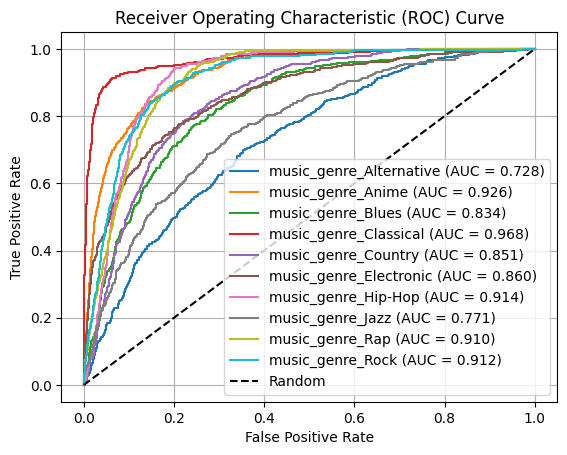

Genre: music_genre_Alternative
Precision: 0.810
Recall: 0.900
F1-Score: 0.853

Genre: music_genre_Anime
Precision: 0.916
Recall: 0.925
F1-Score: 0.917

Genre: music_genre_Blues
Precision: 0.856
Recall: 0.897
F1-Score: 0.862

Genre: music_genre_Classical
Precision: 0.958
Recall: 0.959
F1-Score: 0.958

Genre: music_genre_Country
Precision: 0.844
Recall: 0.900
F1-Score: 0.853

Genre: music_genre_Electronic
Precision: 0.903
Recall: 0.916
F1-Score: 0.899

Genre: music_genre_Hip-Hop
Precision: 0.870
Recall: 0.894
F1-Score: 0.877

Genre: music_genre_Jazz
Precision: 0.862
Recall: 0.900
F1-Score: 0.862

Genre: music_genre_Rap
Precision: 0.882
Recall: 0.903
F1-Score: 0.887

Genre: music_genre_Rock
Precision: 0.883
Recall: 0.903
F1-Score: 0.888

AUC Scores:
music_genre_Alternative: 0.728
music_genre_Anime: 0.926
music_genre_Blues: 0.834
music_genre_Classical: 0.968
music_genre_Country: 0.851
music_genre_Electronic: 0.860
music_genre_Hip-Hop: 0.914
music_genre_Jazz: 0.771
music_genre_Rap: 0.910
mu

In [ ]:
# Logistic Regression 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


genres = ['music_genre_Alternative', 'music_genre_Anime', 'music_genre_Blues',
          'music_genre_Classical', 'music_genre_Country',
          'music_genre_Electronic', 'music_genre_Hip-Hop', 'music_genre_Jazz',
          'music_genre_Rap', 'music_genre_Rock']

# Initialize dictionaries to store classification metrics and AUC scores
metrics = {genre: {} for genre in genres}
auc_scores = {}

# Train and test the Logistic Regression models for each genre
for genre in genres:
    # Get the training and testing data
    X_train_genre = X_train
    y_train_genre = y_train[genre]
    X_test_genre = X_test
    y_test_genre = y_test[genre]

     # Create an imputer object
    imputer = SimpleImputer(strategy='mean')

    # Apply imputation to the training data
    X_train_genre = imputer.fit_transform(X_train_genre)

    # Apply imputation to the testing data (if needed)
    X_test_genre = imputer.transform(X_test_genre)
    
    
    # Train the Logistic Regression model
    clf = LogisticRegression()
    clf.fit(X_train_genre, y_train_genre)
    
    # Test the Logistic Regression model
    y_pred = clf.predict(X_test_genre)
    y_prob = clf.predict_proba(X_test_genre)[:, 1]
    
    # Compute classification metrics
    report = classification_report(y_test_genre, y_pred, output_dict=True)
    metrics[genre]['precision'] = report['weighted avg']['precision']
    metrics[genre]['recall'] = report['weighted avg']['recall']
    metrics[genre]['f1-score'] = report['weighted avg']['f1-score']
    
    # Compute AUC score
    auc_scores[genre] = roc_auc_score(y_test_genre, y_prob)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test_genre, y_prob)
    plt.plot(fpr, tpr, label=f'{genre} (AUC = {auc_scores[genre]:.3f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print classification metrics
for genre in genres:
    print(f"Genre: {genre}")
    print(f"Precision: {metrics[genre]['precision']:.3f}")
    print(f"Recall: {metrics[genre]['recall']:.3f}")
    print(f"F1-Score: {metrics[genre]['f1-score']:.3f}")
    print("")

# Print AUC scores
print("AUC Scores:")
for genre in genres:
    print(f"{genre}: {auc_scores[genre]:.3f}")


## Neural Networks

In [ ]:
#!pip show tensorflow

In [ ]:
# This will display the path to the currently active Python interpreter. 
# Check if it matches the environment where you installed TensorFlow.
##import sys
#print(sys.executable)

In [ ]:
#pwd

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


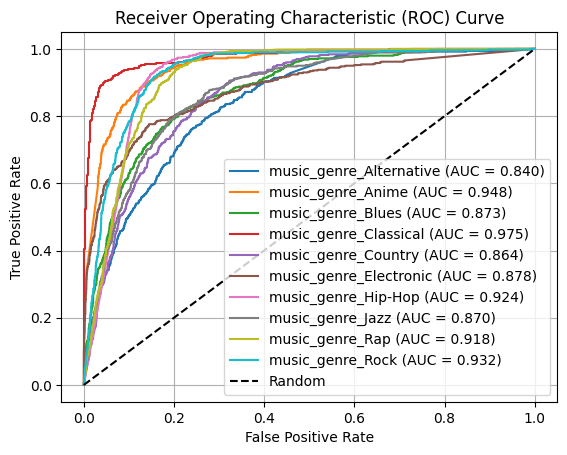

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer


genres = ['music_genre_Alternative', 'music_genre_Anime', 'music_genre_Blues',
          'music_genre_Classical', 'music_genre_Country',
          'music_genre_Electronic', 'music_genre_Hip-Hop', 'music_genre_Jazz',
          'music_genre_Rap', 'music_genre_Rock']

# Initialize dictionaries to store classification metrics and AUC scores
metrics = {genre: {} for genre in genres}
auc_scores = {}



# Train and test the Neural Network models for each genre
for genre in genres:
    # Get the training and testing data
    X_train_genre = X_train
    y_train_genre = y_train[genre]
    X_test_genre = X_test
    y_test_genre = y_test[genre]


    # Create an imputer object
    imputer = SimpleImputer(strategy='mean')

    # Apply imputation to the training data
    X_train_genre = imputer.fit_transform(X_train_genre)

    # Apply imputation to the testing data (if needed)
    X_test_genre = imputer.transform(X_test_genre)
    
    # Train the Neural Network model
    
    clf = MLPClassifier(hidden_layer_sizes=(2, 4, 2))
    clf.fit(X_train_genre, y_train_genre)
    
    # Test the Neural Network model
    y_pred = clf.predict(X_test_genre)
    y_prob = clf.predict_proba(X_test_genre)[:, 1]
    
    # Compute classification metrics
    report = classification_report(y_test_genre, y_pred, output_dict=True)
    metrics[genre]['precision'] = report['weighted avg']['precision']
    metrics[genre]['recall'] = report['weighted avg']['recall']
    metrics[genre]['f1-score'] = report['weighted avg']['f1-score']
    
    # Compute AUC score
    auc_scores[genre] = roc_auc_score(y_test_genre, y_prob)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test_genre, y_prob)
    plt.plot(fpr, tpr, label=f'{genre} (AUC = {auc_scores[genre]:.3f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print classification metrics
for genre in genres:
    print(f"Genre: {genre}")
    print(f"Precision: {metrics[genre]['precision']:.3f}")
    print(f"Recall: {metrics[genre]['recall']:.3f}")
    print(f"F1-Score: {metrics[genre]['f1-score']:.3f}")
    print("")

# Print AUC scores
print("AUC Scores:")
for genre in genres:
    print(f"{genre}: {auc_scores[genre]:.3f}")



# Extra Credit 
One interesting analysis is to explore the relationship between the popularity of songs and their corresponding genres. I therefore examine whether certain genres tend to have higher popularity ratings compared to others.

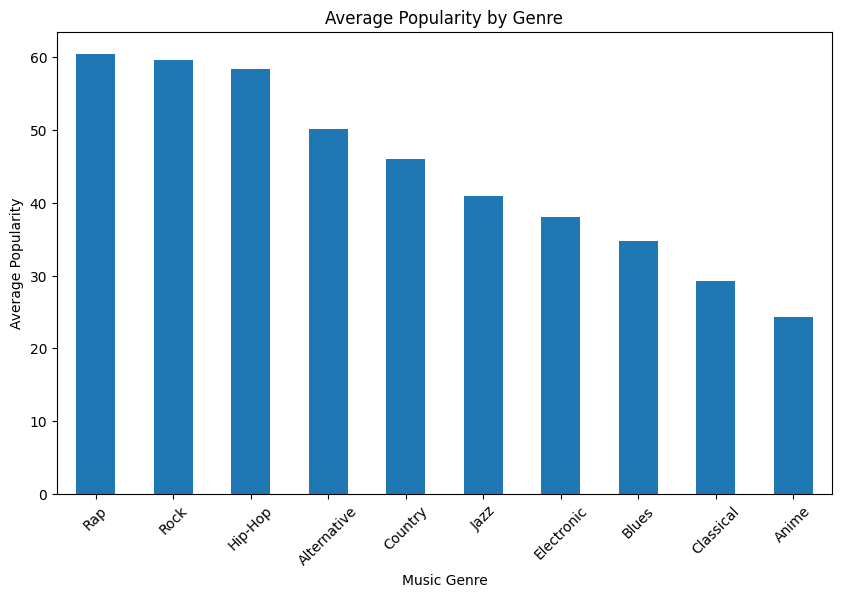

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset and select relevant columns (artist_name, track_name, popularity, music_genre)

# Group the data by music_genre and calculate the average popularity for each genre

# Loading the dataset into a Pandas Dataframe 
df = pd.read_csv("musicData.csv") 
genre_popularity = df.groupby('music_genre')['popularity'].mean().sort_values(ascending=False)

# Plot the average popularity by genre
plt.figure(figsize=(10, 6))
genre_popularity.plot(kind='bar')
plt.xlabel('Music Genre')
plt.ylabel('Average Popularity')
plt.title('Average Popularity by Genre')
plt.xticks(rotation=45)
plt.show()


This code will calculate the average popularity for each genre and create a bar plot showing the average popularity values. We can use this visualization to identify genres that tend to have higher or lower popularity ratings.